# Logistic Regression Implementation

In [39]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

import torch
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Source code for [Logistc.py](https://github.com/leftmire/lizrightmireio.github.io/blob/main/posts/LogisticRegression/logistic.py)

### Abstract

Logistic Regression is a popular machine learning algorithm most commonly used in classification problems. In this blog post, I will create an object-oriented implementation of Logistic Regression. Then, I will perform a series of experiments to test the efficacy of Logistic Regression in different scenarios. First I consider vanilla gradient descent, in which the momentum term $\beta$ is set to 0. Next I adjust $\beta$ to a positive, nonzero value to see how introducing momentum into the algorithm allows for faster convergence. Finally, I investigate overfitting in Logistic Regression, seeing how a model can have a training accuracy of 100%, yet only 86% accuracy on a separate, testing dataset.

### Experiments

### Vanilla Gradient Descent

To begin, I will implement "vanilla" gradient descent, in which the momentum term, $\beta$, is 0. Referring to the equation below, setting $\beta$ to 0 cancels out the last term. The step in the gradient descent algorithm is computed as $\alpha$ * the gradient of the loss function.  
$\mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1}) $

First, define functions to generate and plot our classification data, and one to draw the decision boundary we'll find next.

In [40]:
# generate data for classification problem
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):   
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

In [41]:
# function to plot classification data
def plotter(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["*" , "o"]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "jet", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

In [42]:
# function to draw decision boundary
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

Plot the classification data we'll work with

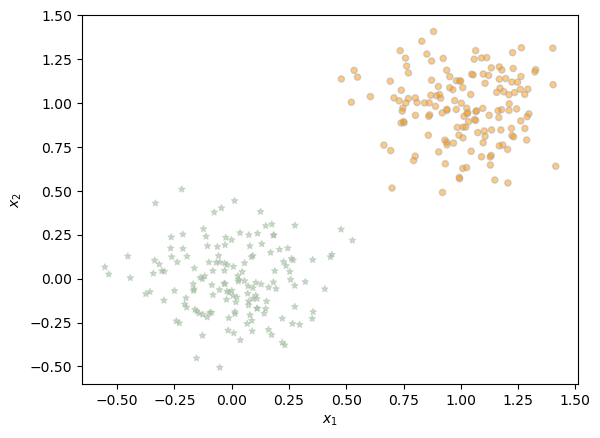

In [43]:
X, y = classification_data(noise = 0.2)
fig, ax = plt.subplots(1,1)
plotter(X,y,ax)

We have two distinct classes of points, and our goal is to find a decision boundary between them. 

We can now train our logistic model and follow our progress by plotting the loss vs. the current iteration. We'll save the final weight vector before the loop terminates to plot the decision boundary.

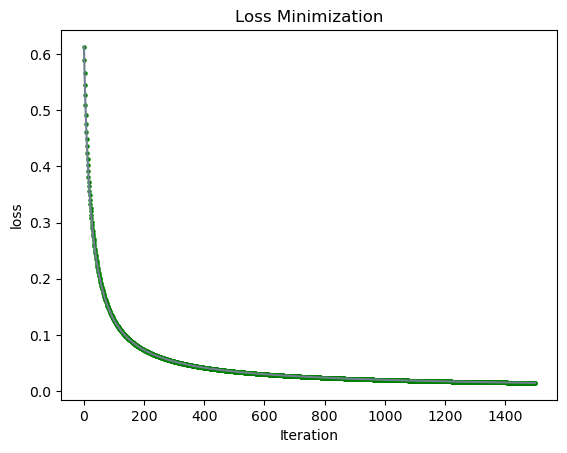

In [44]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

# training loop
for index in range(1500):
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.3, beta = 0)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

# save final weights for graphing decision boundary
final_weights = LR.w
    
def plot_loss(loss_vec, color):
    plt.plot(loss_vec, color = "slategrey")
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = color, s = 5)
    plt.gca().set(xlabel = "Iteration", ylabel = "loss")
    plt.title("Loss Minimization")

plot_loss(loss_vec, "green")

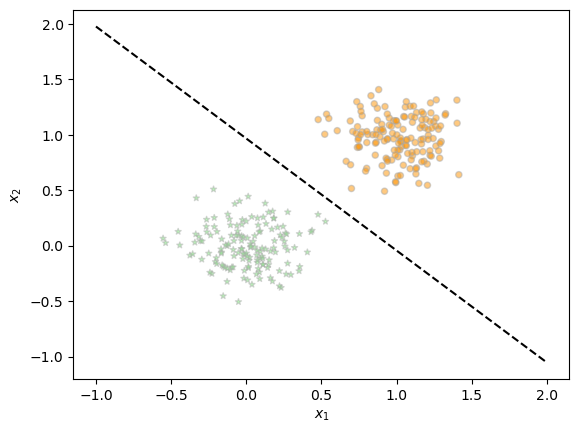

In [45]:
# plot decision boundary
fig, ax = plt.subplots(1,1)
plotter(X, y, ax)
draw_line(final_weights, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

The decision boundary found using vanilla gradient descent is a perfect match!

### Benefits of Momentum

Vanilla gradient descent was very effective, but we can do better. Adjusting the momentum term $\beta$ to a value other than 0 allows gradient descent to converge in fewer iterations. 

$\mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1}) $

Now that $\beta$ is not 0, The final term, or momentum term, is factored into the step calculation. The size of the difference between the current weights and previous iteration's weights have an impact on the size of the step.

Let's prove this to ourselves.

Train a logistic regression model with $\beta$ = 0.9

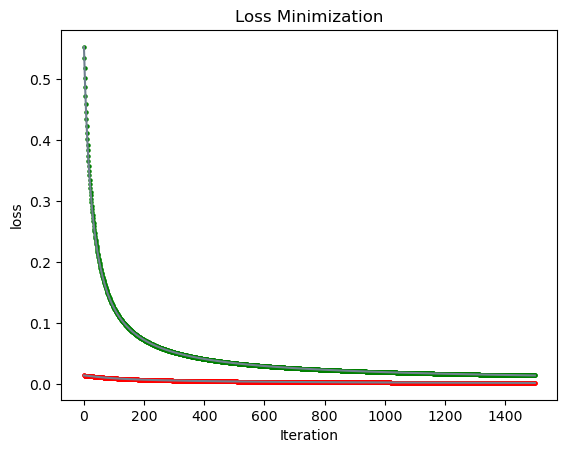

In [53]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []
loss_vec_momentum = []

# training loop -- beta = 0
for index in range(1500):
    opt.step(X, y, alpha = 0.3, beta = 0)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

# training loop -- momentum beta = 0.9
for index in range(1500):
    # adjust momentum term
    opt.step(X, y, alpha = 0.3, beta = 0.9)
    loss = LR.loss(X, y).item()
    loss_vec_momentum.append(loss)

# save final weights for graphing decision boundary
final_weights = LR.w

plot_loss(loss_vec_momentum, "red")
plot_loss(loss_vec, "green")

The green line represents vanilla gradient descent, whereas the red line is gradient descent with momentum. With momentum, we see significant improvements -- the initial loss is much lower, and the loss stays lower than vanilla gradient descent for each iteration up until 1,500. 

### Overfitting

Logistic Regression models have the tendency to overfit. Let's explore this pattern.

Generate train and test data where p_dim > n_points.

In [47]:
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

Fit the model on the training data

In [48]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

# training loop
for index in range(100):
    opt.step(X_train, y_train, alpha = 0.3, beta = 0)

final_weights = LR.w

We obtain an accuracy of 100% on the training data. This should raise concern that we may have oveffit!

In [49]:
# Accuracy on training data
(1.0*(LR.predict(X_train) == y_train)).mean()

tensor(1.)

Indeed, accuracy is much lower -- 0.84 -- on the testing data.

In [50]:
# Accuracy on testing data
(1.0*(LR.predict(X_test) == y_test)).mean()

tensor(0.9000)

### Discussion

In this blog post, I set out to perform a deeper dive into a stalwart in the machine larning world: logistic regression. Instead of relying on sklearn's implementation as I have done in the past, I built my own logistic regression model and tested it in a variety of scenarios. The intricacies of the gradient and loss equations became more concrete as I toyed with tensors to produce the desired result. 

Beginning with vanilla gradient descent, I observed how the loss fell to zero and the decision bounary was stored in weights. Then, I dove into the theory behind momentum (how and why does it work?) and set $\beta$ to 0.9 such that the momentum term of the step function would be at play. Finally, I saw how logistic regression can overfit -- something I'll be wary of in future projects. 